# Points patterns

Points differ from polygons in:
- Rather than exhausting the entire space, points can be events subject to occur anywhere
- The location of the event is part of what we are trying to understand/model
- The interest focuses on characterizing the pattern that the points follow over space
Ex: crime, analysis of species distribution, social media distribution, ...

Assumption is a point can happen anywhere on that space, but only happens in specific locations. Two types:
- unmarked: location only
- marked: values attached to each point


## Visualisation points

1. One-to-one mapping -> Scatter plot
- Intuitive
- Only effective in small datasets
- Limited as size increases until useless 

2. Aggregation -> Histogram
- Use a polygon boundary and count points per area
- BUT, polygons need to make sense (segmentation of space needs to relate to the point generating process)
- Hex-binning:
    - Hexagons are regular
    - Exhaust the space (unlike circles)
    - All the neigbours have the same boundary, a hexagon segment, in comparison to when we use squares that some neigbours share a point and others a segment.

3. Smooth -> KDE
- Estimate the continuous observed distribution of a variable
- Probability of finding an observation at a given location
- Continuous histogram
- Solves (much of) the MAUP problem, but not the underlying population issue

In [76]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from ipywidgets import interact, fixed

In [77]:
# Read remote file
tokyo = pd.read_csv(
    "https://geographicdata.science/book/_downloads/7fb86b605af15b3c9cbd9bfcbead23e9/tokyo_clean.csv"
)

# Read the file in
areas = gpd.read_file(
    "https://darribas.org/gds_course/content/data/tokyo_admin_boundaries.geojson"
)

In [78]:
# Geo-referenced photographs in Tokyo
tokyo.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06


In [79]:
areas.head()

,GID_1,NAME_1,GID_2,NAME_2,ENGTYPE_2,geometry
0,JPN.4_1,Chiba,JPN.4.10_1,Ichikawa,City,"MULTIPOLYGON (((139.9765 35.68272, 139.97583 3..."
1,JPN.4_1,Chiba,JPN.4.25_1,Matsudo,City,"MULTIPOLYGON (((139.97223 35.76775, 139.97018 ..."
2,JPN.19_1,Kanagawa,JPN.19.14_1,Kawasaki,City,"MULTIPOLYGON (((139.74057 35.5416, 139.7411 35..."
3,JPN.19_1,Kanagawa,JPN.19.29_1,Yokohama,City,"MULTIPOLYGON (((139.62944 35.40111, 139.62917 ..."
4,JPN.35_1,Saitama,JPN.35.2_1,Asaka,City,"MULTIPOLYGON (((139.62227 35.81256, 139.62088 ..."


<Axes: >

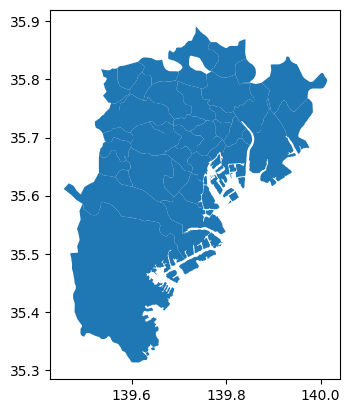

In [80]:
areas.plot()

In [81]:
# Map the points from tokyo (represented by longitude and latitude) with the admin_area of the polygon each point belongs to

tokyo_gdf = gpd.GeoDataFrame(
    {
        "geometry": gpd.points_from_xy(
            tokyo["longitude"], tokyo["latitude"]
        )
    }, crs="EPSG:4326"
).join(tokyo)

crosswalk = gpd.sjoin(tokyo_gdf, areas, how="inner")
tokyo["admin_area"] = crosswalk["GID_2"]

In [82]:
tokyo_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

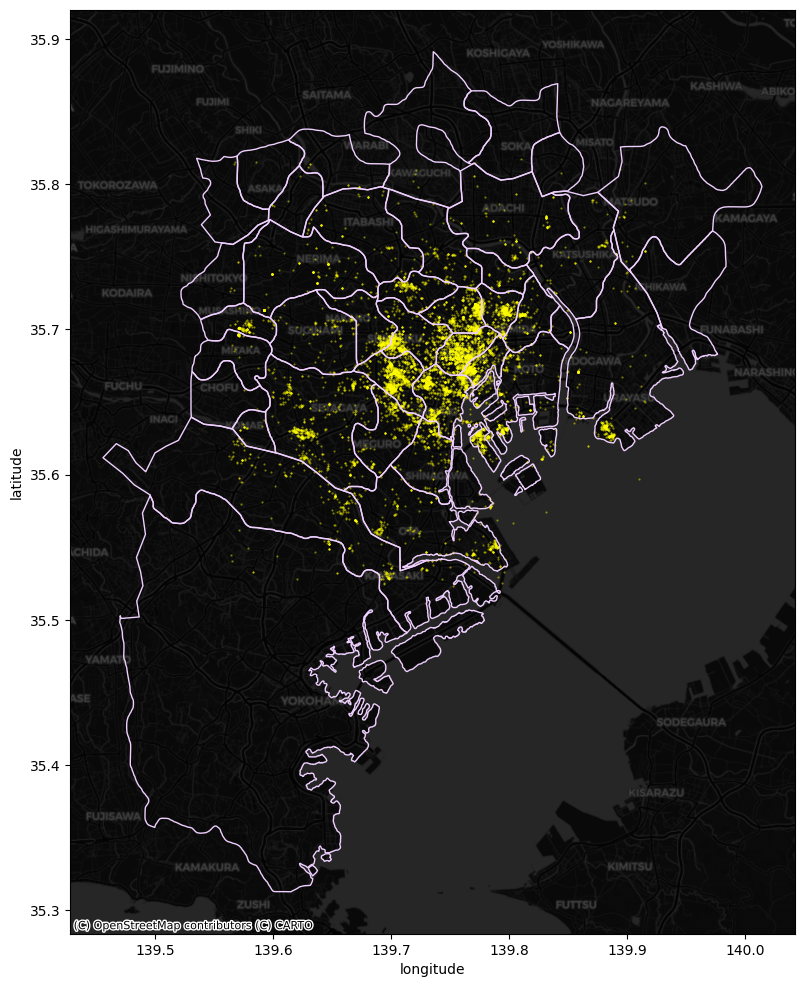

In [83]:
# Plot a dot for every image
ax = tokyo.plot.scatter(
    "longitude",
    "latitude",
    s=0.25,
    c="xkcd:bright yellow",
    alpha=0.5,
    figsize=(12, 12))

areas.plot(
    ax=ax,
    facecolor="none",
    edgecolor="xkcd:pale lavender"
)

cx.add_basemap(ax, crs=tokyo_gdf.crs, source=cx.providers.CartoDB.DarkMatter)

Count how many photos (yellow points) there are per admin area

In [84]:
# Create counts
photos_by_area = tokyo.groupby("admin_area").size()

# Assign counts into a table of its own
# and joins it to the areas table
areas = areas.join(
    pd.DataFrame({"photo_count": photos_by_area}),
    on="GID_2"
)

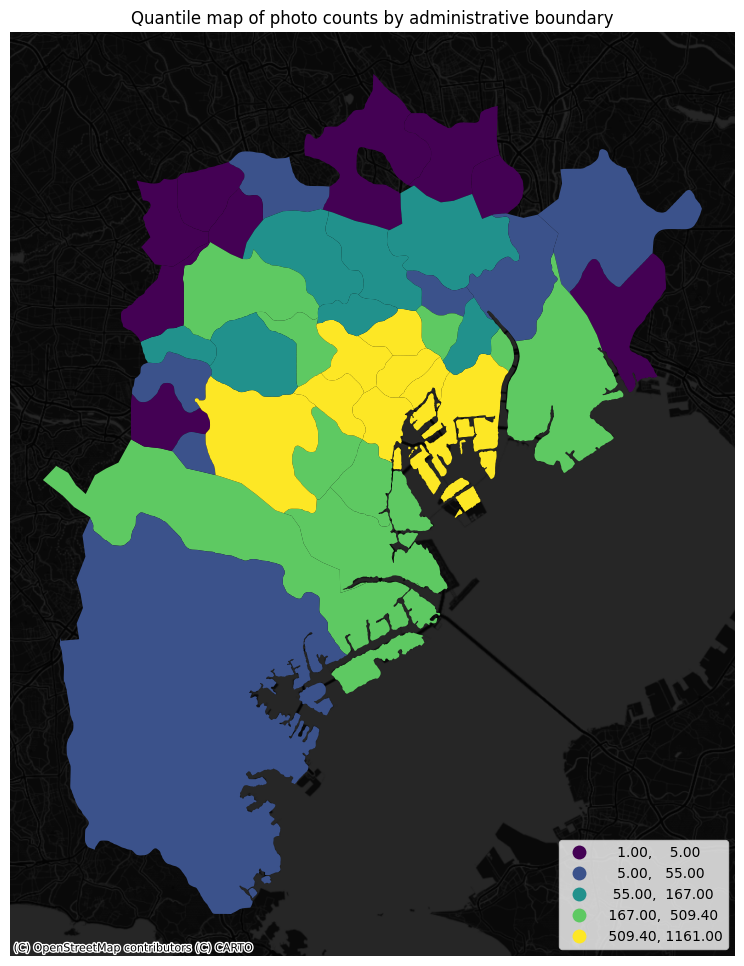

In [110]:
f, ax = plt.subplots(1, figsize=(12, 12))
# Plot the equal interval choropleth and add a legend
areas.plot(
    column='photo_count',
    scheme='quantiles',
    ax=ax,
    legend=True,
    legend_kwds={"loc": 4}
)
ax.set_axis_off()
ax.set_title("Quantile map of photo counts by administrative boundary")

cx.add_basemap(
    ax,
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

plt.show()

In [22]:
# To calculate more fairly we should take into account the area of each polygon.

areas["area_sqm"] = areas.to_crs(epsg=2459).area * 1e-6
areas["photo_density"] = areas["photo_count"] / areas["area_sqm"]

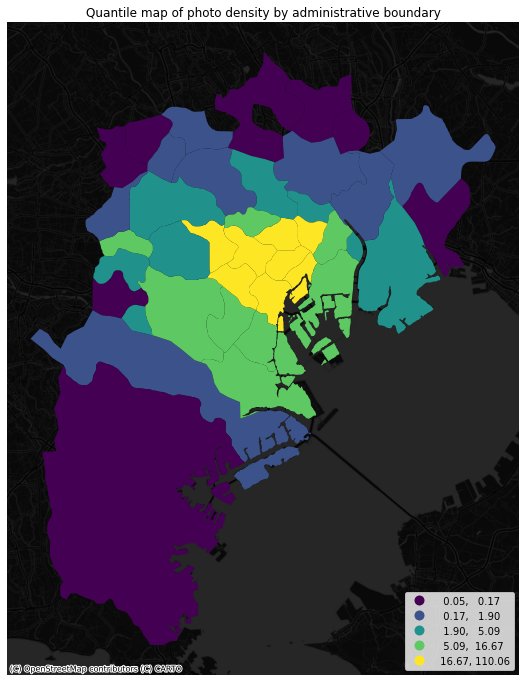

In [24]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Plot the equal interval choropleth and add a legend
areas.plot(
    column='photo_density',
    scheme='quantiles',
    ax=ax,
    legend=True,
    legend_kwds={"loc": 4}
)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Quantile map of photo density by administrative boundary")
# Add dark basemap
cx.add_basemap(
    ax,
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Draw map
plt.show()

## Regular lattices: hex-binning

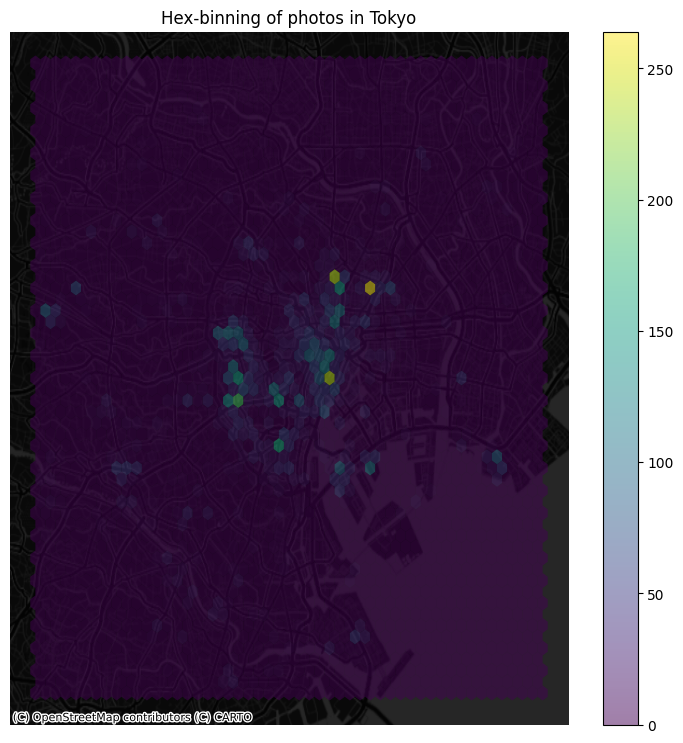

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))

# Add hexagon layer that displays count of points in each polygon
hb = ax.hexbin(
    tokyo["longitude"],
    tokyo["latitude"],
    gridsize=50,
    alpha=0.5,
    edgecolor="none"
)
# Add a colorbar (optional)
plt.colorbar(hb)

ax.set_axis_off()

cx.add_basemap(
    ax,
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Add title of the map
ax.set_title("Hex-binning of photos in Tokyo")
# Draw map
plt.show()

## Kernel Density Estimation

In [25]:
# Take a random subset of 1,000 rows from `tokyo` becuase the computation for the 10000 rows can be expensive
tokyo_sub = tokyo.sample(1000, random_state=12345)

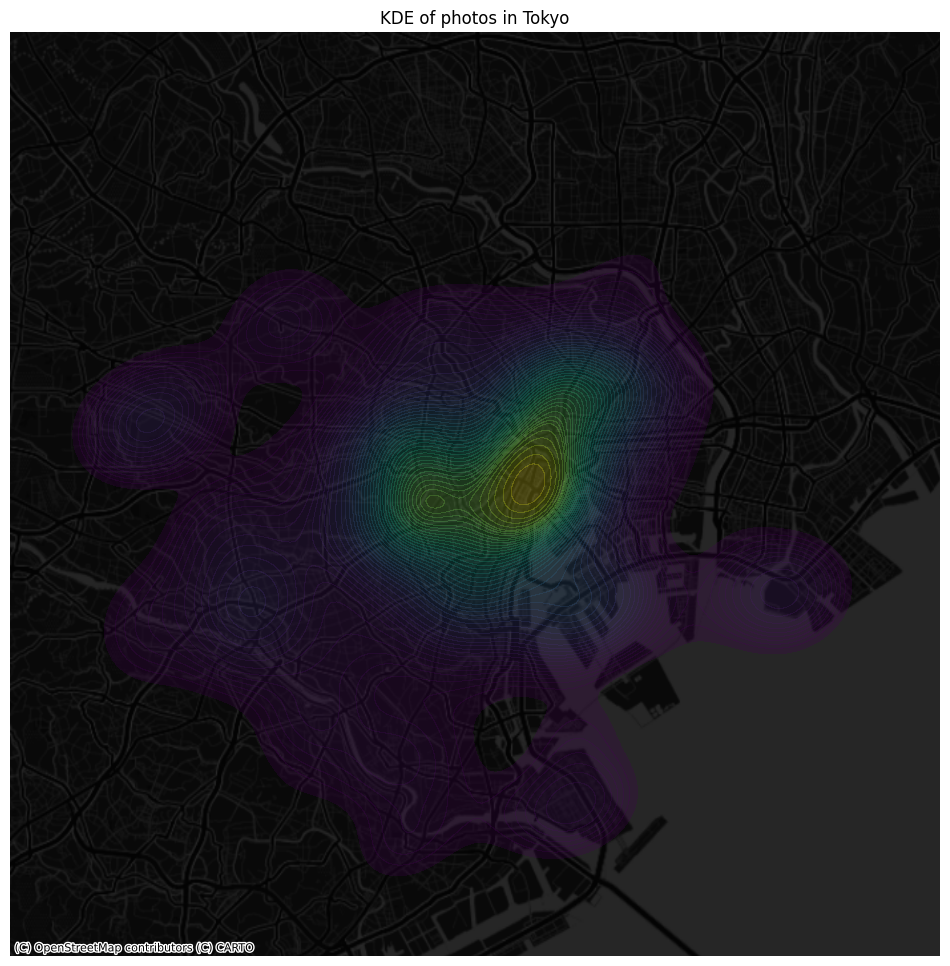

In [27]:
f, ax = plt.subplots(1, figsize=(12, 12))

sns.kdeplot(
    x='longitude',
    y='latitude',
    data=tokyo_sub,
    n_levels=50,
    fill=True,
    alpha=0.25,
    cmap="viridis"
)

ax.set_axis_off()

cx.add_basemap(
    ax,
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Add title of the map
ax.set_title("KDE of photos in Tokyo")
plt.show()

In [108]:
tokyo.columns

Index(['user_id', 'longitude', 'latitude', 'date_taken',
       'photo/video_page_url', 'x', 'y', 'admin_area'],
      dtype='object')

## Clusters of points

In [28]:
algo = DBSCAN(eps=100, min_samples=50) # clusters with more than 50 photos within 100 metres apart

In [ ]:
algo.fit(tokyo[["x", "y"]])

DBSCAN(eps=100, min_samples=50)

In [33]:
algo.labels_

array([-1, -1, -1, ..., 10, -1, -1], shape=(10000,))

In [32]:
algo.core_sample_indices_[:5]

array([12, 25, 28, 46, 63])

In [35]:
# Turn the labels into a Series object so we can index
lbls = pd.Series(algo.labels_, index=tokyo.index)
lbls

0       -1
1       -1
2       -1
3       -1
4       10
        ..
9995    -1
9996    -1
9997    10
9998    -1
9999    -1
Length: 10000, dtype: int64

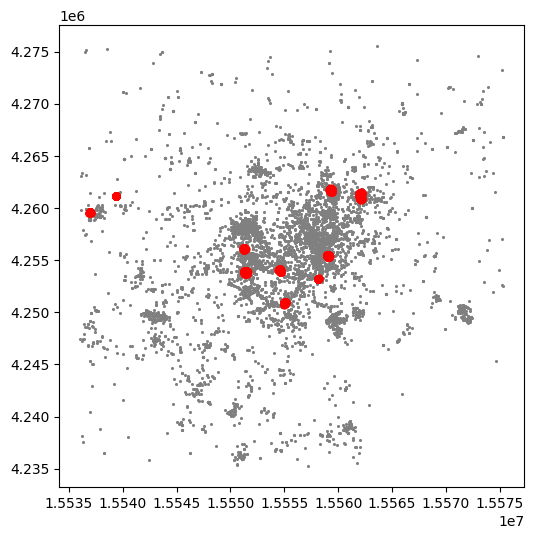

In [36]:
f, ax = plt.subplots(1, figsize=(6, 6))

# Assign labels to tokyo table dynamically and
# subset points that are not part of any cluster (noise)
noise = tokyo.assign(
    lbls=lbls
).query("lbls == -1")

# Plot noise in grey
ax.scatter(
    noise["x"],
    noise["y"],
    c='grey',
    s=5,
    linewidth=0
)

# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    tokyo.loc[tokyo.index.difference(noise.index), "x"],
    tokyo.loc[tokyo.index.difference(noise.index), "y"],
    c="red",
    linewidth=0
)

plt.show()

In [ ]:
# Clustering with different parameters

algo = DBSCAN(eps=500, min_samples=10)

# Fit to Tokyo projected points
algo.fit(tokyo[["x", "y"]])

# Store labels
lbls = pd.Series(algo.labels_, index=tokyo.index)

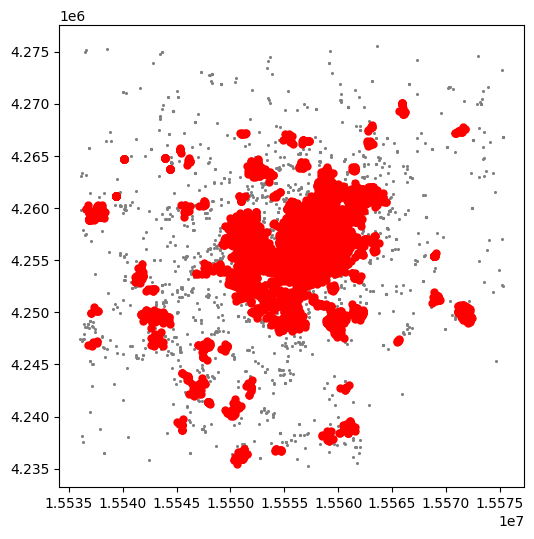

In [41]:
f, ax = plt.subplots(1, figsize=(6, 6))

# Assign labels to tokyo table dynamically and
# subset points that are not part of any cluster (noise)
noise = tokyo.assign(
    lbls=lbls
).query("lbls == -1")

# Plot noise in grey
ax.scatter(
    noise["x"],
    noise["y"],
    c='grey',
    s=5,
    linewidth=0
)

# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    tokyo.loc[tokyo.index.difference(noise.index), "x"],
    tokyo.loc[tokyo.index.difference(noise.index), "y"],
    c="red",
    linewidth=0
)

plt.show()

In [42]:
def clusters(db, eps, min_samples):
    '''
    Compute and visualize DBSCAN clusters
    ...

    Arguments
    ---------
    db          : (Geo)DataFrame
                  Table with at least columns `X` and `Y` for point coordinates
    eps         : float
                  Maximum radious to search for points within a cluster
    min_samples : int
                  Minimum number of points in a cluster
    '''
    algo = DBSCAN(eps=eps, min_samples=min_samples)
    algo.fit(db[['X_metres', 'Y_metres']])
    lbls = pd.Series(algo.labels_, index=db.index)

    f, ax = plt.subplots(1, figsize=(6, 6))
    noise = db.loc[lbls==-1, ['X_metres', 'Y_metres']]
    ax.scatter(noise['X_metres'], noise['Y_metres'], c='grey', s=5, linewidth=0)
    ax.scatter(
        db.loc[db.index.difference(noise.index), 'X_metres'],
        db.loc[db.index.difference(noise.index), 'Y_metres'],
        c='red',
        linewidth=0
    )
    return plt.show()

In [ ]:
interact(
    clusters,                 # Method to make interactive
    db=fixed(tokyo),          # Data to pass on db (does not change)
    eps=(50, 500, 50),        # Range start/end/step of eps
    min_samples=(50, 300, 50) # Range start/end/step of min_samples
);

interactive(children=(IntSlider(value=250, description='eps', max=500, min=50, step=50), IntSlider(value=150, …

# Do-It-Yourself

## Task II: Clusters of Indian cities

In [68]:
url = (
    "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/"
    "ne_50m_populated_places_simple.geojson"
)
places = gpd.read_file(url).query("adm0name == 'India'")
places.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 69 entries, 141 to 1243
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   scalerank     69 non-null     int32   
 1   natscale      69 non-null     int32   
 2   labelrank     69 non-null     int32   
 3   name          69 non-null     object  
 4   namepar       7 non-null      object  
 5   namealt       16 non-null     object  
 6   diffascii     69 non-null     int32   
 7   nameascii     69 non-null     object  
 8   adm0cap       69 non-null     int32   
 9   capalt        69 non-null     int32   
 10  capin         0 non-null      object  
 11  worldcity     69 non-null     int32   
 12  megacity      69 non-null     int32   
 13  sov0name      69 non-null     object  
 14  sov_a3        69 non-null     object  
 15  adm0name      69 non-null     object  
 16  adm0_a3       69 non-null     object  
 17  adm1name      69 non-null     object  
 18  iso_a

In [71]:
places_m = places.to_crs(epsg=24378)

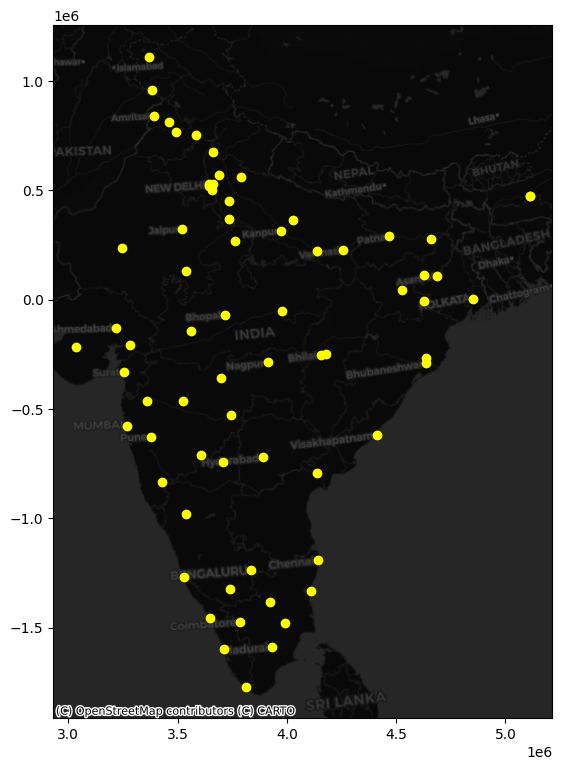

In [73]:
ax = places_m.plot(color="xkcd:bright yellow", figsize=(9, 9))
cx.add_basemap(
    ax,
    crs=places_m.crs,
    source=cx.providers.CartoDB.DarkMatter
)

1. Use the DBSCAN algorithm to identify clusters
2. Start with the following parameters: at least five cities for a cluster (min_samples) and a maximum of 1,000Km (eps)
3. Obtain the clusters and plot them on a map. Does it pick up any interesting pattern?
4. Based on the results above, tweak the values of both parameters to find a cluster of southern cities, and another one of cities in the North around New Dehli

In [121]:
# Write the X and Y coordinates of the points into separate columns
places_m['X'] = places_m.geometry.x
places_m['Y'] = places_m.geometry.y

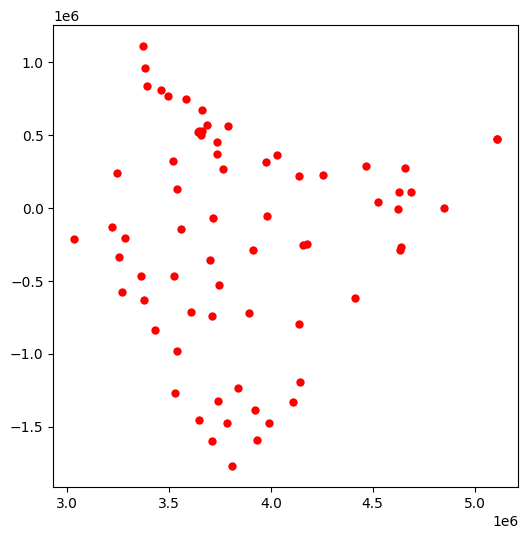

In [150]:
algo = DBSCAN(eps=100000000, min_samples=5)

algo.fit(places_m[["X", "Y"]])

lbls = pd.Series(algo.labels_, index=places_m.index)



f, ax = plt.subplots(1, figsize=(6, 6))
# Assign labels to tokyo table dynamically and
# subset points that are not part of any cluster (noise)
noise = places_m.assign(lbls=lbls).query("lbls == -1")

# Plot noise in grey
ax.scatter(noise["X"],
           noise["Y"],
           c='grey',
           s=5,
           linewidth=0
          )

# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(places_m.loc[places_m.index.difference(noise.index), "X"],
           places_m.loc[places_m.index.difference(noise.index), "Y"],
           c="red",
           linewidth=0)

plt.show()